### Outline
* Implementing a custom LangGraph graph
* Trying with simple story bot

In [ ]:
'''
working
    v 0.5

outline
    DONE v 0.1 langgraph chatbot based implementation
        default prompt and purpose
        implements a minimal example based on that prompt
        asks for user feedback ends
    DONE v 0.2 add a second LLM as an editor
        second LLM as an editor
    DONE v 0.3 add LLM editor and critic
        DONE add edge from editor to critic
        STOPPED HERE NEED TO DEBUG
            pass the correct output from states. need to be explicit
                https://stackoverflow.com/questions/78503492/why-is-my-state-not-being-passed-correctly-in-my-langgraph-workflow
                https://langchain-ai.github.io/langgraph/tutorials/introduction/#requirements
        conditional edge from critic to writer if doesn't like.
            issue is I'm asking the critic to decide befor it gets the message
            so need to do critic's node first
            then do a node for critic routing
        pass editor output and critic output to writer
            might be done by memory
        conditional edge from writer to user if needs more help
        
        DONE something to stop the loops

    DONE v 0.4 understand the flow a bit better
        stopping and inspecting the state and graph
        DONE langsmith
        human intervention

    v 0.5 enhancements
        TEST runnable like interface and binding the LLM
        
        DONE enhancements from teh chatbots tutorials
            go through and add ideas to the backlog

        ask human example confirmation rather than looping through
            think this and through a bit
            
        better output for the text
            final thing htat is printed out and run by the user for either improvement or completion
            not necessarily a loop. more like a new prompt with the other messages and context
        
    v 0.6
        back log items?
        maybe images?

backlog
    better output for the text
    set up anthropic key
    different naems for the assistants
    improved prompt templates
    improved prompts with n shot context
    langsmith
    incorporate images
        find something cheap for first
    better interface
        notebook -> gradio/langchain default -> node.js
    cicd
    example from code assistant and binding hte interface for ht e output

    keep track of your state
    enhanced context
    enhanced memory
    streaming

    critic node count not working properly

    tool use
    writer goes back to user for more information
        see this tutorial for some examples
        https://langchain-ai.github.io/langgraph/tutorials/chatbots/information-gather-prompting/

    reflection

    
'''

### v0.1 Langraph chatbot
* https://langchain-ai.github.io/langgraph/tutorials/introduction/#setup

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

In [9]:
from typing import Annotated

#from langchain_anthropic import ChatAnthropic
from langchain_openai import OpenAI, ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


#llm = ChatAnthropic(model="claude-3-haiku-20240307")
#llm = OpenAI(model_name=)
llm = ChatOpenAI(model_name="gpt-3.5-turbo")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: Hello! How can I assist you today?
Assistant: The capital of Nova Scotia is Halifax.
Goodbye!


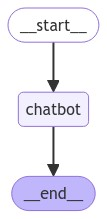

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### v0.2 Add the editor

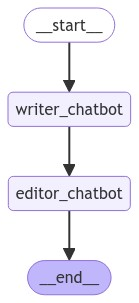

In [23]:
from typing import Annotated

#from langchain_anthropic import ChatAnthropic
from langchain_openai import OpenAI, ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


#llm = ChatAnthropic(model="claude-3-haiku-20240307")
#llm = OpenAI(model_name=)
writer_llm = ChatOpenAI(model_name="gpt-3.5-turbo")
editor_llm = ChatOpenAI(model_name="gpt-3.5-turbo")

# Define the prompts
writer_prompt = '''
    You are a creative writer. Please write a short story for children under five years old based on the following input.
    The story should be no more than 10 sentences.
    '''

editor_prompt = '''
    You are an editor. Please review and edit the following story for clarity, brevity, and grammar.
    The story is for children under five years old. The story should be no more than 10 sentences.
    '''


def writer_chatbot(state: State):
    state["messages"].append(("system", writer_prompt))

    response = writer_llm.invoke(state["messages"])

    state["messages"].append(response)

    return state
    

def editor_chatbot(state: State):
    state["messages"].append(("system", editor_prompt))

    response = editor_llm.invoke(state["messages"])

    state["messages"].append(response)
    return state
    


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("writer_chatbot", writer_chatbot)
graph_builder.add_node("editor_chatbot", editor_chatbot)

graph_builder.set_entry_point("writer_chatbot")
graph_builder.set_finish_point("editor_chatbot")

graph_builder.add_edge("writer_chatbot", "editor_chatbot")
#graph_builder.add_edge("editor_chatbot", "writer_chatbot")


graph = graph_builder.compile()


from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [40]:
import pprint

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        #for value in event.values():
        for key, value in event.items():
            #print("Assistant:", value["messages"][-1].content)
            message_str = f'''{key}: {value["messages"][-1].content}'''
            pprint.pprint(message_str)


('writer_chatbot: Once upon a time, in a cozy little pond, there lived a happy '
 'green frog named Freddy. Freddy loved to hop around and play all day long. '
 'One sunny morning, he met a friendly duck named Daisy. They quickly became '
 'best friends and spent their days swimming and exploring together. One day, '
 'a big storm came and flooded the pond. Freddy and Daisy had to work together '
 'to find a safe place to hide. They found a hollow log and huddled together '
 'until the storm passed. After the storm, the sun came out and the pond was '
 'even more beautiful than before. Freddy and Daisy were grateful for each '
 "other's friendship and continued to have fun adventures together. And from "
 'that day on, they knew that no matter what challenges came their way, they '
 'could always count on each other. The end.')
('editor_chatbot: Once upon a time, in a cozy pond, there lived a happy green '
 'frog named Freddy. Freddy loved to hop and play all day. One sunny morning, '


### v0.3 add the critic

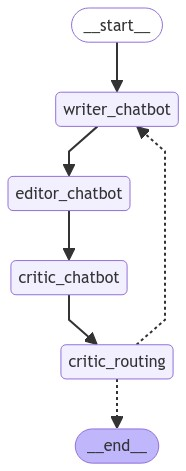

In [53]:
from typing import Annotated

#from langchain_anthropic import ChatAnthropic
from langchain_openai import OpenAI, ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

import json


class State(TypedDict):
    messages: Annotated[list, add_messages]
    critic_node_count: int


graph_builder = StateGraph(State)


#llm = ChatAnthropic(model="claude-3-haiku-20240307")
#llm = OpenAI(model_name=)
writer_llm = ChatOpenAI(model_name="gpt-3.5-turbo")
editor_llm = ChatOpenAI(model_name="gpt-3.5-turbo")
critic_llm = ChatOpenAI(model_name="gpt-3.5-turbo")

# Define the prompts
writer_prompt = '''
    You are a creative writer. Please write a short story for children under five years old based on the following input.
    The story should be no more than 10 sentences.
    '''

editor_prompt = '''
    You are an editor. Please review and edit the following story for clarity, brevity, and grammar.
    The story is for children under five years old. The story should be no more than 10 sentences.
    '''

critic_prompt = '''
    You are a literary critic of a children's story. Please provide concise feedback on the following story for children under five years old.
    If the story is good, provide positive feedback. If the story needs improvement, provide constructive criticism and send the story back to the writer.
    Your output should be less than 50 words.

    Output your format as a JSON object with the following keys:
        "critic_grade": "good" or "bad"
        "critic_comments": "Your comments here"

    Example 1:
    {
        "critic_grade": "good",
        "critic_comments": "I enjoyed the story. It was engaging and imaginative."
    }

    Example 2:
    {
        "critic_grade": "bad",
        "critic_comments': "The story is not appropriate for young children. It is not age appropriate"
    }
    '''


def writer_chatbot(state: State):
    state["messages"].append(("system", writer_prompt))

    response = writer_llm.invoke(state["messages"])

    return {"messages": [response], "critic_node_count": 0}
    

def editor_chatbot(state: State):
    state["messages"].append(("system", editor_prompt))

    response = editor_llm.invoke(state["messages"])

    return {"messages": [response], "critic_node_count": 0}
    

# def increment_node_call_count(state: State, node_name: str):
#     if "node_call_counts" not in state:
#         state["node_call_counts"] = {}
#     if node_name not in state["node_call_counts"]:
#         state["node_call_counts"][node_name] = 0
#     state["node_call_counts"][node_name] += 1

#     return state


def critic_chatbot(state: State):
    #state = increment_node_call_count(state, "critic_chatbot")
    state["messages"].append(("system", critic_prompt))

    response = critic_llm.invoke(state["messages"])

    num_critic_visits = state.get("critic_node_count", 0)
    num_critic_visits += 1
    # state["messages"].append(response)
    # print("in critic_chatbot ")
    # print(state.keys())
    # print(state["messages"][-1])
    # print(state["messages"][-2])

    return {"messages": [response], "critic_node_count": num_critic_visits}


def route_critic_decision(state: State):
    # print("in route_critic_decision ")
    # print(state.keys())
    # print(state["messages"][-1])
    # print(state["messages"][-2])

    return state



def select_critic_next_node(state: State):

    critic_grade_key = 'critic_grade'
    critic_grade_bad = 'bad'
    critic_grade_good = 'good'
    critic_comments_key = 'critic_comments'

    critic_decision_writer = 'writer_chatbot'
    critic_decision_end = '__end__'
    critic_decision = critic_decision_end

    critic_node_calls = state.get("critic_node_count", 10)

    if critic_node_calls > 2:
        print("Warning: critic node called too many times")
        critic_decision = critic_decision_end
    else:

        try:
            critic_message = state['messages'][-1]

            critic_message_parsed = json.loads(critic_message.content)

            if critic_grade_key in critic_message_parsed:
                critic_grade = critic_message_parsed[critic_grade_key]

                if critic_grade == critic_grade_bad:
                    critic_decision = critic_decision_writer
                else:
                    critic_decision = critic_decision_end
            else:
                print("Warning: critic unable to find grade in message")
        except Exception:
            print("Warning: critic message parsing failed")
 
    return critic_decision


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("writer_chatbot", writer_chatbot)
graph_builder.add_node("editor_chatbot", editor_chatbot)
graph_builder.add_node("critic_chatbot", critic_chatbot)
graph_builder.add_node("critic_routing", route_critic_decision)

graph_builder.set_entry_point("writer_chatbot")
#graph_builder.set_finish_point("critic_chatbot")

graph_builder.add_edge("writer_chatbot", "editor_chatbot")
graph_builder.add_edge("editor_chatbot", "critic_chatbot")
graph_builder.add_edge("critic_chatbot", "critic_routing")



graph_builder.add_conditional_edges(
    "critic_routing",
    select_critic_next_node,
    {"writer_chatbot": "writer_chatbot", "__end__": "__end__"},
)


graph = graph_builder.compile(checkpointer=memory)


from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [54]:
import pprint

config = {"configurable": {"thread_id": "1"}}

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}, config):
        #for value in event.values():
        for key, value in event.items():
            #print("Assistant:", value["messages"][-1].content)
            message_str = f'''{key}: {value["messages"][-1].content}'''
            pprint.pprint(message_str)

('writer_chatbot: Once upon a time, there was a fluffy dog named Max. Max '
 'loved to play fetch with his favorite red ball. Every day, he would run '
 'around the yard, wagging his tail with joy. Max had a shiny black nose and '
 'big floppy ears that bounced as he ran. One day, Max met a new friend, a '
 "little girl named Lily. Lily loved to pet Max's soft fur and give him "
 'treats. Max was so happy to have a new friend to play with. They spent all '
 'day running and laughing together. From that day on, Max and Lily were the '
 'best of friends, sharing many fun adventures together. Max was the happiest '
 'dog in the world because he had found a friend who loved him just as much as '
 'he loved her. And they lived happily ever after, playing and laughing '
 'together every day. The end.')
('editor_chatbot: Once upon a time, there was a fluffy dog named Max who loved '
 'to play fetch with his favorite red ball. Every day, he would run around the '
 'yard, wagging his tail with 

In [30]:
snapshot = graph.get_state(config)
pprint.pprint(snapshot)

StateSnapshot(values={'messages': [HumanMessage(content='write a story about a dog', id='87e9f850-cd53-4266-9f92-44303c7eb819'), SystemMessage(content='\n    You are a creative writer. Please write a short story for children under five years old based on the following input.\n    The story should be no more than 10 sentences.\n    ', id='77fe1101-55d6-435b-8dfc-e01a915b2218'), AIMessage(content='Once upon a time, there was a fluffy dog named Max. Max had soft, brown fur and big, floppy ears. He loved to run and play in the park with his friends. Every day, Max would wag his tail happily as he chased after his favorite ball. He would bark with excitement when he saw his owner coming to take him for a walk. Max was a friendly dog who loved to give sloppy kisses to everyone he met. He would curl up in his cozy bed at night, dreaming of all the fun adventures he had that day. Max was the best companion anyone could ask for, always loyal and loving. And so, Max lived happily ever after, bri

#### debugging

#### testing json output

In [ ]:
# import json
# asdf = json.loads("{\"asdf\": \"asdf\"}")
# asdf

In [55]:
# import json
# from langchain_openai import ChatOpenAI

# # Initialize the model
# model = ChatOpenAI(model_name="gpt-3.5-turbo")

# # Define the prompt
# prompt = '''
#     Please provide a JSON object with the following keys:
#     "name": "John Doe",
#     "age": 30,
#     "city": "New York"
# '''

# # Get the response from the model
# response = model.invoke([("user", prompt)])

# # Extract the JSON string from the response
# json_string = response["choices"][0]["message"]["content"]

# # Parse the JSON string into a Python dictionary
# data = json.loads(json_string)

# # Print the parsed JSON object
# print(data)

### v0.4 Inspecting the graph and langsmith

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Aug 2024 Story Project v0.4"

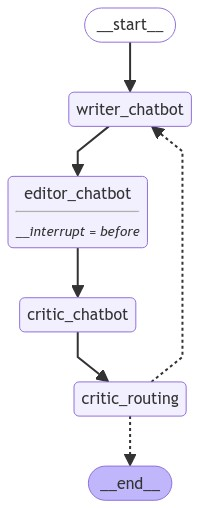

In [5]:
from typing import Annotated

#from langchain_anthropic import ChatAnthropic
from langchain_openai import OpenAI, ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

import json


class State(TypedDict):
    messages: Annotated[list, add_messages]
    critic_node_count: int


graph_builder = StateGraph(State)


#llm = ChatAnthropic(model="claude-3-haiku-20240307")
#llm = OpenAI(model_name=)
writer_llm = ChatOpenAI(model_name="gpt-3.5-turbo")
editor_llm = ChatOpenAI(model_name="gpt-3.5-turbo")
critic_llm = ChatOpenAI(model_name="gpt-3.5-turbo")

# Define the prompts
writer_prompt = '''
    You are a creative writer. Please write a short story for children under five years old based on the following input.
    The story should be no more than 10 sentences.
    '''

editor_prompt = '''
    You are an editor. Please review and edit the following story for clarity, brevity, and grammar.
    The story is for children under five years old. The story should be no more than 10 sentences.
    '''

critic_prompt = '''
    You are a literary critic of a children's story. Please provide concise feedback on the following story for children under five years old.
    If the story is good, provide positive feedback. If the story needs improvement, provide constructive criticism and send the story back to the writer.
    Your output should be less than 50 words.

    Output your format as a JSON object with the following keys:
        "critic_grade": "good" or "bad"
        "critic_comments": "Your comments here"

    Example 1:
    {
        "critic_grade": "good",
        "critic_comments": "I enjoyed the story. It was engaging and imaginative."
    }

    Example 2:
    {
        "critic_grade": "bad",
        "critic_comments': "The story is not appropriate for young children. It is not age appropriate"
    }
    '''


def writer_chatbot(state: State):
    state["messages"].append(("system", writer_prompt))

    response = writer_llm.invoke(state["messages"])

    return {"messages": [response], "critic_node_count": 0}
    

def editor_chatbot(state: State):
    state["messages"].append(("system", editor_prompt))

    response = editor_llm.invoke(state["messages"])

    return {"messages": [response], "critic_node_count": 0}
    

# def increment_node_call_count(state: State, node_name: str):
#     if "node_call_counts" not in state:
#         state["node_call_counts"] = {}
#     if node_name not in state["node_call_counts"]:
#         state["node_call_counts"][node_name] = 0
#     state["node_call_counts"][node_name] += 1

#     return state


def critic_chatbot(state: State):
    #state = increment_node_call_count(state, "critic_chatbot")
    state["messages"].append(("system", critic_prompt))

    response = critic_llm.invoke(state["messages"])

    num_critic_visits = state.get("critic_node_count", 0)
    num_critic_visits += 1
    # state["messages"].append(response)
    # print("in critic_chatbot ")
    # print(state.keys())
    # print(state["messages"][-1])
    # print(state["messages"][-2])

    return {"messages": [response], "critic_node_count": num_critic_visits}


def route_critic_decision(state: State):
    # print("in route_critic_decision ")
    # print(state.keys())
    # print(state["messages"][-1])
    # print(state["messages"][-2])

    return state



def select_critic_next_node(state: State):

    critic_grade_key = 'critic_grade'
    critic_grade_bad = 'bad'
    critic_grade_good = 'good'
    critic_comments_key = 'critic_comments'

    critic_decision_writer = 'writer_chatbot'
    critic_decision_end = '__end__'
    critic_decision = critic_decision_end

    critic_node_calls = state.get("critic_node_count", 10)

    if critic_node_calls > 2:
        print("Warning: critic node called too many times")
        critic_decision = critic_decision_end
    else:

        try:
            critic_message = state['messages'][-1]

            critic_message_parsed = json.loads(critic_message.content)

            if critic_grade_key in critic_message_parsed:
                critic_grade = critic_message_parsed[critic_grade_key]

                if critic_grade == critic_grade_bad:
                    critic_decision = critic_decision_writer
                else:
                    critic_decision = critic_decision_end
            else:
                print("Warning: critic unable to find grade in message")
        except Exception:
            print("Warning: critic message parsing failed")
 
    return critic_decision


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("writer_chatbot", writer_chatbot)
graph_builder.add_node("editor_chatbot", editor_chatbot)
graph_builder.add_node("critic_chatbot", critic_chatbot)
graph_builder.add_node("critic_routing", route_critic_decision)

graph_builder.set_entry_point("writer_chatbot")
#graph_builder.set_finish_point("critic_chatbot")

graph_builder.add_edge("writer_chatbot", "editor_chatbot")
graph_builder.add_edge("editor_chatbot", "critic_chatbot")
graph_builder.add_edge("critic_chatbot", "critic_routing")



graph_builder.add_conditional_edges(
    "critic_routing",
    select_critic_next_node,
    {"writer_chatbot": "writer_chatbot", "__end__": "__end__"},
)


graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["editor_chatbot"],
    # interrupt_after=["critic_chatbot"],
    )


from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### Playing with interrupted state
* remove the loop or the interrupt will go to the next loop
* add into the graph where you want the interrupts to be
* langsmith results is in teh langsmith URL
* can inspect the snapshots to debug. can manually overritw or jump through time with the snapshots as well
* can resume the stream with teh code below


In [7]:
import pprint

config = {"configurable": {"thread_id": "1"}}

#while True:
user_input = input("User: ")
# if user_input.lower() in ["quit", "exit", "q"]:
#     print("Goodbye!")
#     break
events = graph.stream(
    {"messages": ("user", user_input)}, config, #stream_mode="values"
)
for event in events:
    #for value in event.values():
    for key, value in event.items():
        #print("Assistant:", value["messages"][-1].content)
        message_str = f'''{key}: {value["messages"][-1].content}'''
        pprint.pprint(message_str)

# # resuming human interrupt (if doing human interrupt) 
# Resume the graph by streaming with an input of None and the existing config.

# events = graph.stream(None, config, stream_mode="values")
# for event in events:
#     if "messages" in event:
#         event["messages"][-1].pretty_print()

# events = graph.stream(None, config, stream_mode="values")
# for event in events:
#     if "messages" in event:
#         event["messages"][-1].pretty_print()

('writer_chatbot: Once upon a time, in the magical land of Giraffetopia, there '
 'lived a special giraffe named Rosie. Rosie had a beautiful heart-shaped spot '
 'on her neck that shimmered in the sunlight. She spent her days exploring the '
 'colorful forests and playing with her animal friends. One sunny morning, '
 'Rosie discovered a hidden rainbow pond deep in the woods. The pond was '
 'filled with sparkling water that shimmered in all the colors of the rainbow. '
 'Excited, Rosie invited all her friends to join her for a magical swim. As '
 'they splashed and played, the water turned into a rainbow slide, and they '
 'giggled with delight as they slid down together. From that day on, the '
 'rainbow pond became their favorite place to play and make wonderful '
 "memories. And Rosie's heart-shaped spot glowed even brighter, spreading "
 'happiness throughout Giraffetopia. The end.')


In [10]:
# inspecting
snapshot = graph.get_state(config)
print(snapshot.next)
print(snapshot.values["messages"][-1])

('editor_chatbot',)
content="Once upon a time, in the magical land of Giraffetopia, there lived a special giraffe named Rosie. Rosie had a beautiful heart-shaped spot on her neck that shimmered in the sunlight. She spent her days exploring the colorful forests and playing with her animal friends. One sunny morning, Rosie discovered a hidden rainbow pond deep in the woods. The pond was filled with sparkling water that shimmered in all the colors of the rainbow. Excited, Rosie invited all her friends to join her for a magical swim. As they splashed and played, the water turned into a rainbow slide, and they giggled with delight as they slid down together. From that day on, the rainbow pond became their favorite place to play and make wonderful memories. And Rosie's heart-shaped spot glowed even brighter, spreading happiness throughout Giraffetopia. The end." additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 173, 'prompt_tokens': 487, 'total_token

In [11]:
# resuming
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Once upon a time, in the magical land of Giraffetopia, there lived a special giraffe named Rosie. Rosie had a beautiful heart-shaped spot on her neck that shimmered in the sunlight. She spent her days exploring the colorful forests and playing with her animal friends. One sunny morning, Rosie discovered a hidden rainbow pond deep in the woods. The pond was filled with sparkling water that shimmered in all the colors of the rainbow. Excited, Rosie invited all her friends to join her for a magical swim. As they splashed and played, the water turned into a rainbow slide, and they giggled with delight as they slid down together. From that day on, the rainbow pond became their favorite place to play and make wonderful memories. And Rosie's heart-shaped spot glowed even brighter, spreading happiness throughout Giraffetopia. The end.
================================== Ai Message =================================

### v0.5 Runnable interface et al

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Aug 2024 Story Project v0.4"

In [ ]:
from typing import Annotated, Literal, Optional

from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import AnyMessage, add_messages

#from langchain_anthropic import ChatAnthropic
from langchain_openai import OpenAI, ChatOpenAI
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver

import json

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import Runnable, RunnableConfig


memory = MemorySaver()


def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    critic_node_count: int
    # dialog_state: Annotated[
    #     list[
    #         Literal[
    #             "writer_chatbot",
    #             "editor_chatbot",
    #             "critic_chatbot",
    #         ]
    #     ],
    #     update_dialog_stack,
    # ]

In [ ]:
class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}
    

In [ ]:
writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            '''You are a creative writer. Please write a short story for children under five years old based on the following input.
            The story should be no more than 10 sentences.''',
        ),
        ("placeholder", "{messages}"),
    ]
)

editor_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            '''You are an editor. Please review and edit the following story for clarity, brevity, and grammar.
            The story is for children under five years old. The story should be no more than 10 sentences.''',
        ),
        ("placeholder", "{messages}"),
    ]
)

critic_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            '''
            You are a literary critic of a children's story. Please provide concise feedback on the following story for children under five years old.
            If the story is good, provide positive feedback. If the story needs improvement, provide constructive criticism and send the story back to the writer.
            Your output should be less than 50 words.

            Output your format as a JSON object with the following keys:
                "critic_grade": "good" or "bad"
                "critic_comments": "Your comments here"

            Example 1:
            {
                "critic_grade": "good",
                "critic_comments": "I enjoyed the story. It was engaging and imaginative."
            }

            Example 2:
            {
                "critic_grade": "bad",
                "critic_comments': "The story is not appropriate for young children. It is not age appropriate"
            }
            ''',
        ),
        ("placeholder", "{messages}"),
    ]
)

#llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm = ChatOpenAI(model_name="gpt-3.5-turbo")

writer_runnable = writer_prompt | llm
editor_runnable = editor_prompt | llm
critic_runnable = critic_prompt | llm



In [ ]:
graph_builder = StateGraph(State)

def writer_chatbot(state: State):
    state["messages"].append(("system", writer_prompt))

    response = writer_llm.invoke(state["messages"])

    return {"messages": [response], "critic_node_count": 0}

def editor_chatbot(state: State):
    state["messages"].append(("system", editor_prompt))

    response = editor_llm.invoke(state["messages"])

    return {"messages": [response], "critic_node_count": 0}

def critic_chatbot(state: State):
    #state = increment_node_call_count(state, "critic_chatbot")
    state["messages"].append(("system", critic_prompt))

    response = critic_llm.invoke(state["messages"])

    num_critic_visits = state.get("critic_node_count", 0)
    num_critic_visits += 1
    # state["messages"].append(response)
    # print("in critic_chatbot ")
    # print(state.keys())
    # print(state["messages"][-1])
    # print(state["messages"][-2])

    return {"messages": [response], "critic_node_count": num_critic_visits}


def route_critic_decision(state: State):
    # print("in route_critic_decision ")
    # print(state.keys())
    # print(state["messages"][-1])
    # print(state["messages"][-2])

    return state



def select_critic_next_node(state: State):

    critic_grade_key = 'critic_grade'
    critic_grade_bad = 'bad'
    critic_grade_good = 'good'
    critic_comments_key = 'critic_comments'

    critic_decision_writer = 'writer_chatbot'
    critic_decision_end = '__end__'
    critic_decision = critic_decision_end

    critic_node_calls = state.get("critic_node_count", 10)

    if critic_node_calls > 2:
        print("Warning: critic node called too many times")
        critic_decision = critic_decision_end
    else:

        try:
            critic_message = state['messages'][-1]

            critic_message_parsed = json.loads(critic_message.content)

            if critic_grade_key in critic_message_parsed:
                critic_grade = critic_message_parsed[critic_grade_key]

                if critic_grade == critic_grade_bad:
                    critic_decision = critic_decision_writer
                else:
                    critic_decision = critic_decision_end
            else:
                print("Warning: critic unable to find grade in message")
        except Exception:
            print("Warning: critic message parsing failed")
 
    return critic_decision

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("writer_chatbot", writer_chatbot)
graph_builder.add_node("editor_chatbot", editor_chatbot)
graph_builder.add_node("critic_chatbot", critic_chatbot)
graph_builder.add_node("critic_routing", route_critic_decision)

graph_builder.set_entry_point("writer_chatbot")
#graph_builder.set_finish_point("critic_chatbot")

graph_builder.add_edge("writer_chatbot", "editor_chatbot")
graph_builder.add_edge("editor_chatbot", "critic_chatbot")
graph_builder.add_edge("critic_chatbot", "critic_routing")

graph_builder.add_conditional_edges(
    "critic_routing",
    select_critic_next_node,
    {"writer_chatbot": "writer_chatbot", "__end__": "__end__"},
)


graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["editor_chatbot"],
    # interrupt_after=["critic_chatbot"],
    )

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import pprint

config = {"configurable": {"thread_id": "1"}}

#while True:
user_input = input("User: ")
# if user_input.lower() in ["quit", "exit", "q"]:
#     print("Goodbye!")
#     break
events = graph.stream(
    {"messages": ("user", user_input)}, config, #stream_mode="values"
)
for event in events:
    #for value in event.values():
    for key, value in event.items():
        #print("Assistant:", value["messages"][-1].content)
        message_str = f'''{key}: {value["messages"][-1].content}'''
        pprint.pprint(message_str)

# # resuming human interrupt (if doing human interrupt) 
# Resume the graph by streaming with an input of None and the existing config.

# events = graph.stream(None, config, stream_mode="values")
# for event in events:
#     if "messages" in event:
#         event["messages"][-1].pretty_print()

# events = graph.stream(None, config, stream_mode="values")
# for event in events:
#     if "messages" in event:
#         event["messages"][-1].pretty_print()